In [16]:
%matplotlib inline  
import feather
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pgmpy
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch, BicScore
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import warnings

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [2]:
%%time
pandas_df = feather.read_dataframe('data/sample_feather')

CPU times: user 866 ms, sys: 540 ms, total: 1.41 s
Wall time: 819 ms


# Discretizing the Response Variables

For the Type of data we will be using here, all the variables are required to be Discrete. Thus we need to Discretize all grade variables from students

In [3]:
grades = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT', 'NU_NOTA_REDACAO']

In [4]:
before = pandas_df[grades].head()

In [5]:
pandas_df['NU_NOTA_CN'] = pd.cut(pandas_df['NU_NOTA_CN'], bins=[-1,300,500,650,850,1000],labels=['muito baixa','baixa','media','alta','muito alta'])
pandas_df['NU_NOTA_CH'] = pd.cut(pandas_df['NU_NOTA_CH'], bins=[-1,300,500,650,850,1000],labels=['muito baixa','baixa','media','alta','muito alta'])
pandas_df['NU_NOTA_LC'] = pd.cut(pandas_df['NU_NOTA_LC'], bins=[-1,300,500,650,850,1000],labels=['muito baixa','baixa','media','alta','muito alta'])
pandas_df['NU_NOTA_MT'] = pd.cut(pandas_df['NU_NOTA_MT'], bins=[-1,300,500,650,850,1000],labels=['muito baixa','baixa','media','alta','muito alta'])
pandas_df['NU_NOTA_REDACAO'] = pd.cut(pandas_df['NU_NOTA_REDACAO'], bins=[-1,300,500,650,850,1000],labels=['muito baixa','baixa','media','alta','muito alta'])

In [6]:
set(pandas_df['NU_NOTA_MT'])

{'alta', 'baixa', 'media', 'muito alta', 'muito baixa'}

In [162]:
len(pandas_df)

442675

In [163]:
before

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
0,465.1,560.4,537.6,522.2,580.0
1,638.9,642.9,622.2,658.8,920.0
2,569.6,566.4,575.1,605.3,640.0
3,570.1,572.5,601.7,701.6,620.0
4,508.9,436.5,489.1,602.8,600.0


In [164]:
pandas_df[grades].head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
0,baixa,media,media,media,media
1,media,media,media,alta,muito alta
2,media,media,media,media,media
3,media,media,media,alta,media
4,media,baixa,baixa,media,media


# Structure Learning
## Some simple tests

In [12]:
len(set(pandas_df['CO_MUNICIPIO_RESIDENCIA'])), len(set(pandas_df['NU_IDADE']))

(5534, 82)

In [19]:
est = HillClimbSearch(pandas_df[grades+['Q00{}'.format(i) for i in range(1,10)]],
                      scoring_method=BicScore(pandas_df[grades+['Q00{}'.format(i) for i in range(1,10)]]))

In [12]:
%%time
best_model = est.estimate()

CPU times: user 3min 42s, sys: 11.1 s, total: 3min 53s
Wall time: 19.5 s


### Variable study - 10% total size

5 variables - 26s

6 variables - 51s (~25s)

7 variables - 100s (~50s)

8 variables (Including Idade) - 180s (~80s)

9 variables (Including Idade)- 288s (~100s)

10 variables (Including Idade) - 480s(~200s)

11 variables (not including Idade) - 720s (~240)

14 variables - 24 minutos

4 variables (Including Residence Code) - 520s


Aparently, it does depent on the number of "categories in a variable". Thus, using the residence code might not be a good idea.

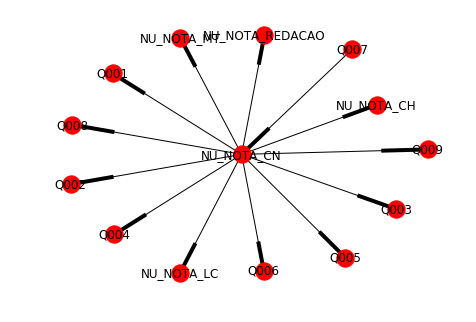

In [81]:
nx.draw(best_model, with_labels=True, pos=graphviz_layout(best_model))
plt.show();

### Variable Study (Taking 10% sample; 1% total)

5 variáveis - 3s

14 variáveos - 4 minutos

16 variáveis - 7 minutos

18 variáveis - 11 minutos

20 variáveis - 17 minutos

24 variáveis - 30 minutos

In [7]:
pandas_sample = pandas_df.sample(frac=0.1,random_state=17)

In [8]:
est = HillClimbSearch(pandas_sample[grades+['Q00{}'.format(i) for i in range(1,10)]],
                      scoring_method=BicScore(pandas_sample[grades+['Q00{}'.format(i) for i in range(1,10)]]))

In [9]:
%%time
best_model = est.estimate()

CPU times: user 4min 33s, sys: 218 ms, total: 4min 33s
Wall time: 4min 33s


In [10]:
len(sorted(best_model.nodes()))

14

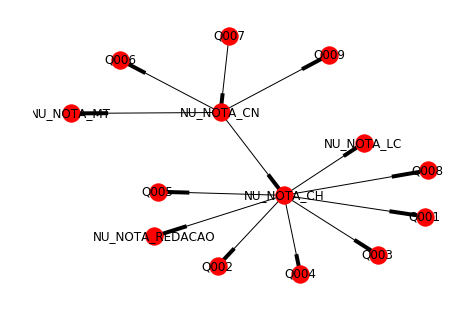

In [11]:
nx.draw(best_model, with_labels=True, pos=graphviz_layout(best_model))
plt.show();

# Increase the feature numbers

Sample Size reduction

- Variable of Interest: `NU_NOTA_MT`
- Only Socialeconomic Questionary Data
- Need to Convert All Variables to Discrete Integers due to Lib requirements

In [8]:
columns = ['NU_NOTA_MT']+['Q00{}'.format(i) for i in range(1,10)]+['Q0{}'.format(i) for i in range(10,28)]

In [9]:
sample_subset = pandas_sample[columns].copy()
sample_subset = sample_subset.reset_index(drop=True)
sample_subset.head()

,NU_NOTA_MT,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,media,C,B,C,B,2.0,C,A,B,B,B,A,B,A,B,A,A,A,A,A,A,A,C,A,B,B,B,A
1,baixa,E,E,A,A,5.0,B,A,B,C,A,B,B,A,A,A,A,A,A,B,B,A,B,A,B,B,B,A
2,alta,F,F,D,D,1.0,G,A,B,B,A,A,B,A,B,A,B,A,B,B,B,B,B,B,B,B,A,A
3,alta,E,E,F,B,3.0,D,A,B,D,B,A,B,B,B,B,B,A,A,B,B,A,C,A,B,B,B,A
4,baixa,A,E,B,B,5.0,A,A,B,C,A,A,B,A,A,A,B,A,A,B,B,A,D,A,A,A,A,A


In [12]:
dict_columns = {}
for column in tqdm(columns):
    transf = LabelEncoder()
    sample_subset[column] = transf.fit_transform(sample_subset[column])
    dict_columns[column] =  transf.classes_

100%|██████████| 28/28 [00:00<00:00, 57.47it/s]


In [13]:
sample_subset.head()

,NU_NOTA_MT,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,2,2,1,2,1,1,2,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,2,0,1,1,1,0
1,1,4,4,0,0,4,1,0,1,2,0,1,1,0,0,0,0,0,0,1,1,0,1,0,1,1,1,0
2,0,5,5,3,3,0,6,0,1,1,0,0,1,0,1,0,1,0,1,1,1,1,1,1,1,1,0,0
3,0,4,4,5,1,2,3,0,1,3,1,0,1,1,1,1,1,0,0,1,1,0,2,0,1,1,1,0
4,1,0,4,1,1,4,0,0,1,2,0,0,1,0,0,0,1,0,0,1,1,0,3,0,0,0,0,0


In [14]:
est = HillClimbSearch(sample_subset,
                      scoring_method=BicScore(sample_subset))

In [ ]:
%%time
best_model = est.estimate()

In [17]:
len(sorted(best_model.nodes()))

28

First Model

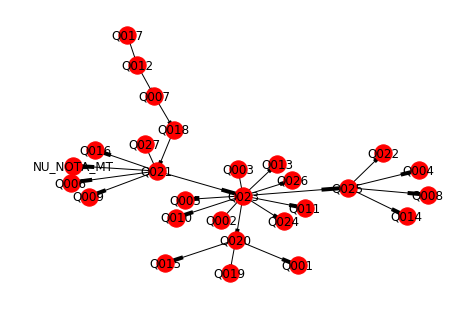

In [18]:
nx.draw(best_model, with_labels=True, pos=graphviz_layout(best_model))
plt.show();

Most Recent Model

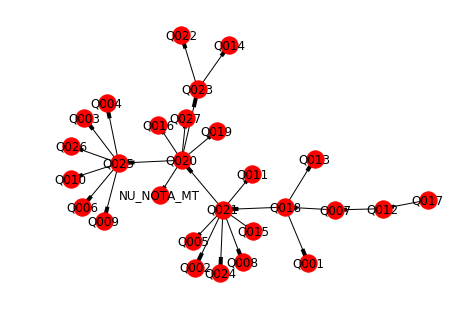

In [18]:
nx.draw(best_model, with_labels=True, pos=graphviz_layout(best_model))
plt.show();

### Interesting relationships

Na sua residência tem TV por assinatura? (21) -> Na sua residência tem aparelho de DVD?(20) -> Na sua residência tem acesso à Internet? (25)

Na sua residência tem aparelho de DVD?(20) -> Na sua residência tem telefone fixo? (23) -> Na sua residência tem telefone celular? (22)

Na sua residência tem aparelho de DVD?(20) -> NU_NOTA_MT 

# Parameter Learning

Using Bayesian Estimator

First, the structure has not parameterization at all

In [53]:
for cpd in best_model.get_cpds():
    print(cpd)

,NU_NOTA_MT,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,media,B,D,B,B,3.0,F,A,B,B,A,A,B,A,B,A,B,A,B,C,B,A,C,B,C,B,A,A
1,alta,C,D,C,B,2.0,H,A,C,D,A,B,B,B,A,A,B,A,A,C,A,A,C,A,B,B,A,A
2,media,F,G,E,E,2.0,O,A,C,C,B,A,B,A,B,A,B,A,A,D,B,B,C,B,C,B,C,D
3,alta,B,B,A,A,5.0,B,A,B,D,A,B,B,A,A,A,B,A,A,C,B,A,D,A,B,B,A,A
4,media,C,E,A,B,3.0,B,A,B,D,A,B,B,A,B,A,A,A,A,B,A,A,B,A,B,B,B,A


In [96]:
from pgmpy.estimators import BayesianEstimator
est = BayesianEstimator(best_model, sample_subset)

In [103]:
print(est.estimate_cpd('NU_NOTA_MT', prior_type='BDeu', equivalent_sample_size=1000))

╒═══════════════╤═════════╤═════════╕
│ Q020          │ Q020(0) │ Q020(1) │
├───────────────┼─────────┼─────────┤
│ NU_NOTA_MT(0) │ 0.2     │ 0.2     │
├───────────────┼─────────┼─────────┤
│ NU_NOTA_MT(1) │ 0.2     │ 0.2     │
├───────────────┼─────────┼─────────┤
│ NU_NOTA_MT(2) │ 0.2     │ 0.2     │
├───────────────┼─────────┼─────────┤
│ NU_NOTA_MT(3) │ 0.2     │ 0.2     │
├───────────────┼─────────┼─────────┤
│ NU_NOTA_MT(4) │ 0.2     │ 0.2     │
╘═══════════════╧═════════╧═════════╛


In [121]:
%%time
best_model.fit(pandas_df[columns], estimator=BayesianEstimator, prior_type="K2")

CPU times: user 3min 12s, sys: 9.7 s, total: 3min 22s
Wall time: 26 s


In [122]:
for cpd in best_model.get_cpds():
    print(cpd)

╒═════════════════════════╤═════════╤═════════╕
│ Q020                    │ Q020(A) │ Q020(B) │
├─────────────────────────┼─────────┼─────────┤
│ NU_NOTA_MT(alta)        │ 0.2     │ 0.2     │
├─────────────────────────┼─────────┼─────────┤
│ NU_NOTA_MT(baixa)       │ 0.2     │ 0.2     │
├─────────────────────────┼─────────┼─────────┤
│ NU_NOTA_MT(media)       │ 0.2     │ 0.2     │
├─────────────────────────┼─────────┼─────────┤
│ NU_NOTA_MT(muito alta)  │ 0.2     │ 0.2     │
├─────────────────────────┼─────────┼─────────┤
│ NU_NOTA_MT(muito baixa) │ 0.2     │ 0.2     │
╘═════════════════════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╕
│ Q018    │ Q018(A) │ Q018(B) │
├─────────┼─────────┼─────────┤
│ Q001(A) │ 0.125   │ 0.125   │
├─────────┼─────────┼─────────┤
│ Q001(B) │ 0.125   │ 0.125   │
├─────────┼─────────┼─────────┤
│ Q001(C) │ 0.125   │ 0.125   │
├─────────┼─────────┼─────────┤
│ Q001(D) │ 0.125   │ 0.125   │
├─────────┼─────────┼─────────┤
│ Q001(E) │ 0.125   │ 0.

# Inference

In [123]:
# Doing inference using VariableElimination
from pgmpy.inference import VariableElimination
enem_infer = VariableElimination(best_model)

In [124]:
dict_columns['NU_NOTA_MT']

array(['alta', 'baixa', 'media', 'muito alta', 'muito baixa'],
      dtype=object)

In [125]:
dict_columns['Q001']

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], dtype=object)

In [126]:
dict_columns['Q002']

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], dtype=object)

In [127]:
dict_columns['Q006']

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q'], dtype=object)

In [128]:
dict_columns['Q017']

array(['A', 'B', 'C', 'D', 'E'], dtype=object)

In [129]:
dict_columns['Q020']

array(['A', 'B'], dtype=object)

In [130]:
dict_columns['Q021']

array(['A', 'B'], dtype=object)

In [131]:
dict_columns['Q024']

array(['A', 'B', 'C', 'D', 'E'], dtype=object)

In [132]:
dict_columns['Q025']

array(['A', 'B'], dtype=object)

In [133]:
dict_columns['Q027']

array(['A', 'B', 'C', 'D', 'E'], dtype=object)

## Case 1

- Pais pós graduados (G)
- Salário em torno de 10 mil reais (N)
- Com TV por Assinatura (A)
- Dois computadores (C)
- Com acesso a internet (B)

In [134]:
q = enem_infer.query(variables=['NU_NOTA_MT'], evidence={'Q001': 6,'Q002':6,'Q006':13,'Q021':0,'Q024':2,'Q025':1,'Q017':1})
print(q['NU_NOTA_MT'])

╒══════════════╤═══════════════════╕
│ NU_NOTA_MT   │   phi(NU_NOTA_MT) │
╞══════════════╪═══════════════════╡
│ NU_NOTA_MT_0 │            0.2000 │
├──────────────┼───────────────────┤
│ NU_NOTA_MT_1 │            0.2000 │
├──────────────┼───────────────────┤
│ NU_NOTA_MT_2 │            0.2000 │
├──────────────┼───────────────────┤
│ NU_NOTA_MT_3 │            0.2000 │
├──────────────┼───────────────────┤
│ NU_NOTA_MT_4 │            0.2000 │
╘══════════════╧═══════════════════╛


## Case 2

- Pais nunca estudaram (A)
- Salário em torno de 2500 reais (F)
- Sem TV por Assinatura (B)
- Sem computador (A)
- Sem acesso a internet

In [135]:
q = enem_infer.query(variables=['NU_NOTA_MT'], evidence={'Q001': 0,'Q002':0,'Q006':5,'Q021':1,'Q024':0,'Q025':0})
print(q['NU_NOTA_MT'])

╒══════════════╤═══════════════════╕
│ NU_NOTA_MT   │   phi(NU_NOTA_MT) │
╞══════════════╪═══════════════════╡
│ NU_NOTA_MT_0 │            0.2000 │
├──────────────┼───────────────────┤
│ NU_NOTA_MT_1 │            0.2000 │
├──────────────┼───────────────────┤
│ NU_NOTA_MT_2 │            0.2000 │
├──────────────┼───────────────────┤
│ NU_NOTA_MT_3 │            0.2000 │
├──────────────┼───────────────────┤
│ NU_NOTA_MT_4 │            0.2000 │
╘══════════════╧═══════════════════╛


## Case 3

- Sem DVD em casa

In [136]:
%%time
q = enem_infer.query(variables=['NU_NOTA_MT'], evidence={'Q020':1})
print(q['NU_NOTA_MT'])

╒══════════════╤═══════════════════╕
│ NU_NOTA_MT   │   phi(NU_NOTA_MT) │
╞══════════════╪═══════════════════╡
│ NU_NOTA_MT_0 │            0.2000 │
├──────────────┼───────────────────┤
│ NU_NOTA_MT_1 │            0.2000 │
├──────────────┼───────────────────┤
│ NU_NOTA_MT_2 │            0.2000 │
├──────────────┼───────────────────┤
│ NU_NOTA_MT_3 │            0.2000 │
├──────────────┼───────────────────┤
│ NU_NOTA_MT_4 │            0.2000 │
╘══════════════╧═══════════════════╛
CPU times: user 207 ms, sys: 2.1 ms, total: 210 ms
Wall time: 206 ms


## Case 4

- Com inernet em casa

In [137]:
q = enem_infer.query(variables=['NU_NOTA_MT'], evidence={'Q025':0})
print(q['NU_NOTA_MT'])

╒══════════════╤═══════════════════╕
│ NU_NOTA_MT   │   phi(NU_NOTA_MT) │
╞══════════════╪═══════════════════╡
│ NU_NOTA_MT_0 │            0.2000 │
├──────────────┼───────────────────┤
│ NU_NOTA_MT_1 │            0.2000 │
├──────────────┼───────────────────┤
│ NU_NOTA_MT_2 │            0.2000 │
├──────────────┼───────────────────┤
│ NU_NOTA_MT_3 │            0.2000 │
├──────────────┼───────────────────┤
│ NU_NOTA_MT_4 │            0.2000 │
╘══════════════╧═══════════════════╛


## Case 5

- Parte em escola pública, parte em particular, com Bolsa

In [139]:
# Computing the probability of bronc given smoke.
q = enem_infer.query(variables=['NU_NOTA_MT'], evidence={'Q027':2})
print(q['NU_NOTA_MT'])

## Case 6

- Somente escola Privada

In [ ]:
# Computing the probability of bronc given smoke.
q = enem_infer.query(variables=['NU_NOTA_MT'], evidence={'Q027':3})
print(q['NU_NOTA_MT'])

## Case 7

- Somente escola Pública

In [ ]:
# Computing the probability of bronc given smoke.
q = enem_infer.query(variables=['NU_NOTA_MT'], evidence={'Q027':0})
print(q['NU_NOTA_MT'])